# Document Classification: Spam/Ham

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set https://archive.ics.uci.edu/dataset/94/spambase

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

# Load Libraries and Data

In [45]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

import warnings

warnings.filterwarnings("ignore")  # Reduce number of messages/warnings displayed
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# # metadata 
# print(spambase.metadata) 
  
# # variable information 
# print(spambase.variables) 

In [37]:
#View first 2 rows
X.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_leftbracket,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.000,0.0,0.778,0.00,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.0,0.94,...,0.0,0.0,0.132,0.0,0.372,0.18,0.048,5.114,101,1028


# Checking Dataset for Missing Values

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [41]:
X.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


In [46]:
#Rename column with bracket. It allows for xgboost algorithm to execute
rename_dict = {
    'char_freq_[': 'char_freq_leftbracket'
}

X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

# Load packages

In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split Data for Model Training

In [6]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Define Model and HyperParameter Tuning Search Grid  

A binary XGBoost model was chosen to classify spam emails. Hyperparameter tuning was performed by using GridSearchCV from the Scikit toolkit library. GridSearchCV() allows the search of the best performing parameters and cross validates performance in-tandem. The best performing parameters were:  
* 'alpha': 0.01,
* 'learning_rate': 0.1,
* 'max_depth': 11,
* 'min_child_weight': 2,
* 'n_estimators': 1000

These parameters yielded an average cross validation accuracy score of 96%. However, the test dataset yielded 95.8% accuracy.

In [7]:
%%time #2hrs, 29mins, 18s run time

# Define the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid
param_grid = {
    "max_depth": np.arange(start=3, stop=15, step=4),  # Default = 6
    "alpha": np.logspace(-3, -1, 5),  # default = 0
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15, 0.3],  # default = 0.3
    "min_child_weight": np.arange(start=2, stop=10, step=3),  # default = 1
    "n_estimators": [100, 200, 1000],
}

#HPO and fit model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy',error_score='raise')
grid_search.fit(X_train, y_train)

CPU times: user 2h 28min 2s, sys: 1min 16s, total: 2h 29min 18s
Wall time: 25min 16s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'alpha': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.3],
                         'max_depth': array([ 3,  7, 11]),
                         'min_child_weight': array([2, 5, 8]),
                         'n_estimators': [100, 200, 1000]},
             scoring='accuracy')

In [8]:
#Eval model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'alpha': 0.01, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 1000}
Best cross-validation score: 0.96


### Get Scores for X_test Data Partition

In [42]:
best_model = grid_search.best_estimator_

# param_grid = {
#     "max_depth": 7,
#     "alpha": 0.01,
#     "learning_rate": 0.1,
#     "min_child_weight": 5,
#     "n_estimators": 100,
# }

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 95.66%


In [13]:
#Calculate metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9598262757871878
Precision: 0.9591029689186599
Recall: 0.9554365774330749
F1 Score: 0.9572035159502522


# Plot ROC Curve  
There is always a tradeoff between recall (TPR), and precision (FPR). In this document classifier we can see that when adjusting the classification threshold for higher recall (TPR), it exponentially increases precision (FPR).

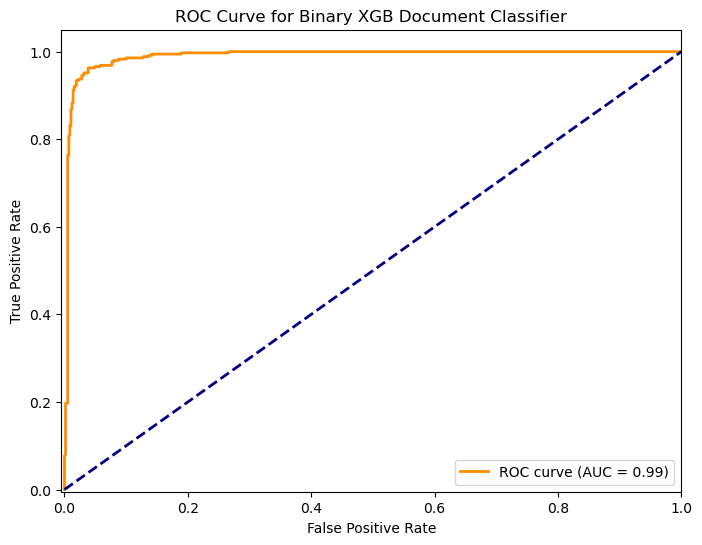

In [34]:
#Extract probabilities
y_probs = best_model.predict_proba(X_test)

#Extract false-positive-rates and true-positive-rates
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
roc_auc = auc(fpr, tpr)

#Plot ROC curve and calculate AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary XGB Document Classifier')
plt.legend(loc="lower right")
plt.savefig('document_classifier_ROC_AUC.png')
plt.show()

# Evaluate Confusion Matrix  
In the confusion matrix and the classification report, it was found that the model performed better in classifiying legitimate emails. Legitimate emails were correctly classified ~97% of the time, whereas spam emails were correctly classified ~94% of the time. 

In [36]:
#performance scores
report_df = pd.DataFrame(classification_report(y_test, 
                                                y_pred, 
                                                output_dict=True)).transpose()
report_df

,precision,recall,f1-score,support
0,0.961938,0.973730,0.967798,571.000000
1,0.956268,0.937143,0.946609,350.000000
accuracy,0.959826,0.959826,0.959826,0.959826
macro avg,0.959103,0.955437,0.957204,921.000000
weighted avg,0.959783,0.959826,0.959746,921.000000


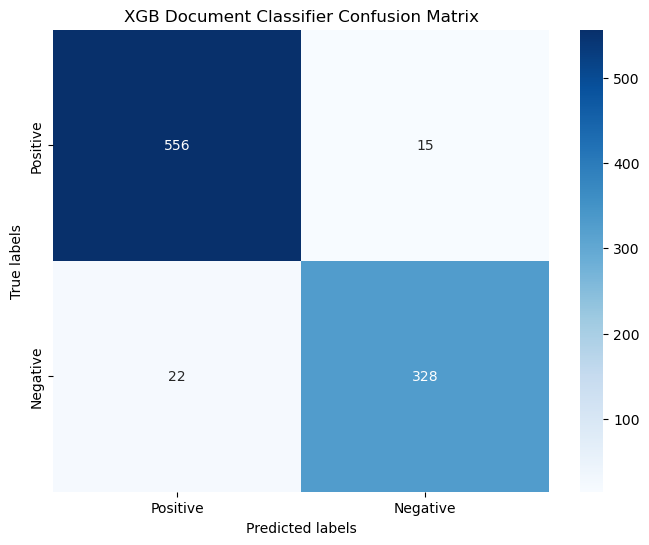

In [32]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('XGB Document Classifier Confusion Matrix')
plt.savefig('XGB_Document_Classifier_Conf_Matrix.png')
plt.show()